<a href="https://colab.research.google.com/github/rasikakaple07/Traffic_Prediction_DSG/blob/main/Traffic_Prediction_DSG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install torch-geometric 
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
import torch
import dgl
import numpy as np
import pandas as pd
from dgl.dataloading import GraphDataLoader
import os
from torch_geometric.data import InMemoryDataset, Data
from shutil import copyfile


In [45]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd '/content/'
!git clone https://github.com/jswang/stgat_traffic_prediction.git
%cd stgat_traffic_prediction

Mounted at /content/drive
/content
Cloning into 'stgat_traffic_prediction'...
remote: Enumerating objects: 693, done.
remote: Total 693 (delta 0), reused 0 (delta 0), pack-reused 693
Receiving objects: 100% (693/693), 22.98 MiB | 12.36 MiB/s, done.
Resolving deltas: 100% (370/370), done.
/content/stgat_traffic_prediction


In [46]:
!wget -q /content/PeMSD7_Full.zip
!unzip -o /content/PeMSD7_Full.zip
data = pd.read_csv("/content/PeMSD7_V_228.csv")
data.head()

Archive:  /content/PeMSD7_Full.zip
  inflating: PeMSD7_V_228.csv        
  inflating: PeMSD7_V_1026.csv       
  inflating: PeMSD7_W_228.csv        
  inflating: PeMSD7_W_1026.csv       


,7.109999999999999432e+01,6.600000000000000000e+01,6.459999999999999432e+01,6.559999999999999432e+01,6.709999999999999432e+01,7.190000000000000568e+01,6.859999999999999432e+01,6.770000000000000284e+01,6.579999999999999716e+01,4.089999999999999858e+01,...,6.909999999999999432e+01.4,7.090000000000000568e+01.2,6.500000000000000000e+01.54,6.450000000000000000e+01.1,6.659999999999999432e+01.2,6.659999999999999432e+01.3,6.500000000000000000e+01.55,6.929999999999999716e+01.3,6.770000000000000284e+01.4,6.890000000000000568e+01.3
0,68.1,66.8,61.7,66.7,64.5,71.6,72.3,64.9,65.6,40.1,...,70.6,65.4,65.0,64.9,65.1,67.7,65.0,67.7,68.8,68.8
1,68.0,64.3,66.6,68.7,68.1,70.5,70.2,61.7,63.4,39.6,...,72.2,70.5,65.0,64.7,66.7,68.9,65.0,70.2,69.1,68.7
2,68.3,67.8,65.9,66.6,67.9,70.3,69.8,67.6,63.2,37.6,...,71.2,69.7,65.0,65.2,67.2,66.9,65.0,70.4,67.3,69.0
3,68.9,69.5,61.2,67.4,64.0,68.1,67.0,66.7,64.2,36.8,...,71.3,65.8,65.0,66.3,66.7,66.2,65.0,68.0,67.4,68.1
4,66.6,69.1,65.1,65.2,68.0,68.8,68.3,66.4,64.1,35.3,...,69.0,71.1,65.0,66.2,67.1,67.0,65.0,69.9,68.0,68.2


In [47]:
def distance_to_weight(W, sigma2=0.1, epsilon=0.5, gat_version=False):
    n = W.shape[0]
    W = W / 10000.
    W2, W_mask = W * W, np.ones([n, n]) - np.identity(n)
    # refer to Eq.10
    W = np.exp(-W2 / sigma2) * (np.exp(-W2 / sigma2) >= epsilon) * W_mask

    # If using the gat version of this, round to 0/1 and include self loops
    if gat_version:
        W[W>0] = 1
        W += np.identity(n)

    return W

In [48]:
class TrafficDataset(InMemoryDataset):
    
    def __init__(self, config, W, root='', transform=None, pre_transform=None):
        self.config = config
        self.W = W
        super().__init__(root, transform, pre_transform)
        self.data, self.slices, self.n_node, self.mean, self.std_dev = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [os.path.join(self.raw_dir, 'PeMSD7_V_228.csv')]

    @property
    def processed_file_names(self):
        return ['./data.pt']

    def download(self):
        copyfile('./dataset/PeMSD7_V_228.csv', os.path.join(self.raw_dir, 'PeMSD7_V_228.csv'))

    def process(self):
        data = pd.read_csv(self.raw_file_names[0], header=None).values
        mean =  np.mean(data)
        std_dev = np.std(data)
        data = z_score(data, np.mean(data), np.std(data))

        _, n_node = data.shape
        n_window = self.config['N_PRED'] + self.config['N_HIST']

        edge_index = torch.zeros((2, n_node**2), dtype=torch.long)
        edge_attr = torch.zeros((n_node**2, 1))
        num_edges = 0
        for i in range(n_node):
            for j in range(n_node):
                if self.W[i, j] != 0.:
                    edge_index[0, num_edges] = i
                    edge_index[1, num_edges] = j
                    edge_attr[num_edges] = self.W[i, j]
                    num_edges += 1
        edge_index = edge_index.resize_(2, num_edges)
        edge_attr = edge_attr.resize_(num_edges, 1)

        sequences = []
        for i in range(self.config['N_DAYS']):
            for j in range(self.config['N_SLOT']):
                g = Data()
                g.__num_nodes__ = n_node

                g.edge_index = edge_index
                g.edge_attr  = edge_attr

                sta = i * self.config['N_DAY_SLOT'] + j
                end = sta + n_window
                full_window = np.swapaxes(data[sta:end, :], 0, 1)
                g.x = torch.FloatTensor(full_window[:, 0:self.config['N_HIST']])
                g.y = torch.FloatTensor(full_window[:, self.config['N_HIST']::])
                sequences += [g]

        data, slices = self.collate(sequences)
        torch.save((data, slices, n_node, mean, std_dev), self.processed_paths[0])


def get_splits(dataset, n_slot, splits):
    split_train, split_val, _ = splits
    i = n_slot*split_train
    j = n_slot*split_val
    train = dataset[:i]
    val = dataset[i:i+j]
    test = dataset[i+j:]

    return train, val, test



In [49]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class ST_GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels, n_nodes, heads=8, dropout=0.0):
        super(ST_GAT, self).__init__()

        # Define model hyperparameters
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes
        self.n_preds = 9
        lstm1_hidden_size = 32
        lstm2_hidden_size = 128

        # Define model layers
        self.gat = GATConv(in_channels=in_channels, out_channels=in_channels, heads=heads, dropout=0, concat=False)
        self.lstm1 = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=lstm1_hidden_size, num_layers=1)
        self.lstm2 = torch.nn.LSTM(input_size=lstm1_hidden_size, hidden_size=lstm2_hidden_size, num_layers=1)
        self.linear = torch.nn.Linear(lstm2_hidden_size, self.n_nodes*self.n_pred)

        # Initialize model weights
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        torch.nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, data, device):
        # Apply dropout
        x, edge_index = data.x, data.edge_index
        if device == 'cpu':
            x = torch.FloatTensor(x)
        else:
            x = torch.cuda.FloatTensor(x)
        x = self.gat(x, edge_index)
        x = F.dropout(x, self.dropout, training=self.training)

        # LSTM layers
        batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        x = torch.movedim(x, 2, 0)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = torch.squeeze(x[-1, :, :])
        x = self.linear(x)

        # Reshape output
        s = x.shape
        x = torch.reshape(x, (s[0], self.n_nodes, self.n_pred))
        x = torch.reshape(x, (s[0]*self.n_nodes, self.n_pred))
        return x



In [50]:
import torch
from tqdm import tqdm

def eval(model, device, dataloader, mode=''):
   
    model.eval()
    model.to(device)

    mae = 0
    rmse = 0
    mape = 0
    n = 0

    # Evaluate model on all data
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch, device)
            truth = batch.y.view(pred.shape)
            if i == 0:
                y_pred = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
                y_truth = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
            truth = un_z_score(truth, dataloader.dataset.mean, dataloader.dataset.std_dev)
            pred = un_z_score(pred, dataloader.dataset.mean, dataloader.dataset.std_dev)
            y_pred[i, :pred.shape[0], :] = pred
            y_truth[i, :pred.shape[0], :] = truth
            rmse += RMSE(truth, pred)
            mae += MAE(truth, pred)
            mape += MAPE(truth, pred)
            n += 1
    rmse, mae, mape = rmse / n, mae / n, mape / n

    print(f'{mode}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')

    # Return the average score for each metric in each batch
    return rmse, mae, mape, y_pred, y_truth

def train(model, device, dataloader, optimizer, loss_fn, epoch):
   
    model.train()
    for _, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}")):
        batch = batch.to(device)
        optimizer.zero_grad()
        y_pred = torch.squeeze(model(batch, device))
        loss = loss_fn()(y_pred.float(), torch.squeeze(batch.y).float())
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()

    return loss


In [51]:
def z_score(x, mean, std):
    
    return (x - mean) / std

def un_z_score(x_normed, mean, std):
   
    return x_normed * std  + mean


def MAPE(v, v_):
   
    return torch.mean(torch.abs((v_ - v)) /(v + 1e-15) * 100)


def RMSE(v, v_):
   
    return torch.sqrt(torch.mean((v_ - v) ** 2))


def MAE(v, v_):
   
    return torch.mean(torch.abs(v_ - v))


In [66]:
import torch
import torch.optim as optim
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

# Create a tensorboard writer
writer = SummaryWriter()

def train_model(train_loader, val_loader, config, device):
    # Define the model architecture
    model = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'], dropout=config['DROPOUT'])
    optimizer = optim.Adam(model.parameters(), lr=config['INITIAL_LR'], weight_decay=config['WEIGHT_DECAY'])
    loss_fn = torch.nn.MSELoss

    # Move the model to the specified device
    model.to(device)

    # Train the model for the specified number of epochs
    for epoch in range(config['EPOCHS']):
        loss = train(model, device, train_loader, optimizer, loss_fn, epoch)
        print(f"Epoch {epoch + 1}/{config['EPOCHS']}: loss = {loss:.3f}")

        # Evaluate the model on the validation dataset every 5 epochs
        if epoch % 5 == 0:
            train_mae, train_rmse, train_mape, _, _ = eval(model, device, train_loader, 'Train')
            val_mae, val_rmse, val_mape, _, _ = eval(model, device, val_loader, 'Valid')
            writer.add_scalar(f"MAE/train", train_mae, epoch)
            writer.add_scalar(f"RMSE/train", train_rmse, epoch)
            writer.add_scalar(f"MAPE/train", train_mape, epoch)
            writer.add_scalar(f"MAE/val", val_mae, epoch)
            writer.add_scalar(f"RMSE/val", val_rmse, epoch)
            writer.add_scalar(f"MAPE/val", val_mape, epoch)

    writer.flush()

    # Save the model
    timestr = time.strftime("%m-%d-%H%M%S")
    torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
            }, os.path.join(config["CHECKPOINT_DIR"], f"model_{timestr}.pt"))

    return model

def test_model(model, test_loader, device, config):
   
    _, _, _, y_pred, y_truth = evaluate(model, device, test_loader, 'Test')


In [60]:
%load_ext tensorboard
%tensorboard --logdir ./runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-04-01 11:18:26.817769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-01 11:18:30.011936: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/usr/local/lib/python3.9/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /usr/local/lib/python3.9/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.9/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /usr/local/lib/python3.9/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.9/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /usr/local/lib/python3

In [67]:
from torch_geometric.loader import DataLoader

config = {
    'BATCH_SIZE': 50,
    'EPOCHS': 60,
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 3e-4,
    'CHECKPOINT_DIR': './runs',
    'N_PRED': 9,
    'N_HIST': 12,
    'DROPOUT': 0.2,
    'N_DAY_SLOT': 288,
    'N_DAYS': 44,
    'USE_GAT_WEIGHTS': True,
    'N_NODE': 228,
}

config['N_SLOT'] = config['N_DAY_SLOT'] - (config['N_PRED'] + config['N_HIST']) + 1

distances = pd.read_csv('./dataset/PeMSD7_W_228.csv', header=None).values
W = distance_to_weight(distances, gat_version=config['USE_GAT_WEIGHTS'])
dataset = TrafficDataset(config, W)

d_train, d_val, d_test = get_splits(dataset, config['N_SLOT'], (34, 5, 5))
train_dataloader = DataLoader(d_train, batch_size=config['BATCH_SIZE'], shuffle=True)
val_dataloader = DataLoader(d_val, batch_size=config['BATCH_SIZE'], shuffle=True)
test_dataloader = DataLoader(d_test, batch_size=config['BATCH_SIZE'], shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

config['N_NODE'] = dataset.n_node
model = train_model(train_dataloader, val_dataloader, config, device)
` `   

Using cpu


Epoch 0: 100%|██████████| 183/183 [00:57<00:00,  3.20it/s]


Epoch 1/60: loss = 0.245
Train, MAE: 4.777907848358154, RMSE: 7.644322395324707, MAPE: 12.214953422546387
Valid, MAE: 4.797582626342773, RMSE: 7.5828986167907715, MAPE: 12.214631080627441


Epoch 1: 100%|██████████| 183/183 [01:09<00:00,  2.64it/s]


Epoch 2/60: loss = 0.326


Epoch 2: 100%|██████████| 183/183 [01:04<00:00,  2.82it/s]


Epoch 3/60: loss = 0.156


Epoch 3: 100%|██████████| 183/183 [01:06<00:00,  2.75it/s]


Epoch 4/60: loss = 0.230


Epoch 4: 100%|██████████| 183/183 [01:06<00:00,  2.77it/s]


Epoch 5/60: loss = 0.252


Epoch 5: 100%|██████████| 183/183 [01:13<00:00,  2.50it/s]


Epoch 6/60: loss = 0.172
Train, MAE: 3.7541563510894775, RMSE: 6.440518856048584, MAPE: 9.55540657043457
Valid, MAE: 3.9553561210632324, RMSE: 6.75154972076416, MAPE: 10.012454986572266


Epoch 6: 100%|██████████| 183/183 [01:09<00:00,  2.64it/s]


Epoch 7/60: loss = 0.190


Epoch 7: 100%|██████████| 183/183 [01:06<00:00,  2.74it/s]


Epoch 8/60: loss = 0.216


Epoch 8: 100%|██████████| 183/183 [01:10<00:00,  2.61it/s]


Epoch 9/60: loss = 0.226


Epoch 9: 100%|██████████| 183/183 [01:06<00:00,  2.74it/s]


Epoch 10/60: loss = 0.188


Epoch 10: 100%|██████████| 183/183 [01:08<00:00,  2.67it/s]


Epoch 11/60: loss = 0.174
Train, MAE: 3.4992969036102295, RMSE: 6.021243095397949, MAPE: 8.73009204864502
Valid, MAE: 3.8362085819244385, RMSE: 6.600098609924316, MAPE: 9.500130653381348


Epoch 11: 100%|██████████| 183/183 [01:07<00:00,  2.69it/s]


Epoch 12/60: loss = 0.210


Epoch 12: 100%|██████████| 183/183 [01:08<00:00,  2.69it/s]


Epoch 13/60: loss = 0.267


Epoch 13: 100%|██████████| 183/183 [01:12<00:00,  2.53it/s]


Epoch 14/60: loss = 0.192


Epoch 14: 100%|██████████| 183/183 [01:08<00:00,  2.67it/s]


Epoch 15/60: loss = 0.253


Epoch 15: 100%|██████████| 183/183 [01:06<00:00,  2.75it/s]


Epoch 16/60: loss = 0.198
Train, MAE: 3.3273799419403076, RMSE: 5.675823211669922, MAPE: 8.335883140563965
Valid, MAE: 3.7393996715545654, RMSE: 6.41925573348999, MAPE: 9.332342147827148


Epoch 16: 100%|██████████| 183/183 [01:07<00:00,  2.70it/s]


Epoch 17/60: loss = 0.188


Epoch 17: 100%|██████████| 183/183 [01:06<00:00,  2.74it/s]


Epoch 18/60: loss = 0.220


Epoch 18: 100%|██████████| 183/183 [01:09<00:00,  2.62it/s]


Epoch 19/60: loss = 0.183


Epoch 19: 100%|██████████| 183/183 [01:06<00:00,  2.76it/s]


Epoch 20/60: loss = 0.176


Epoch 20: 100%|██████████| 183/183 [01:07<00:00,  2.71it/s]


Epoch 21/60: loss = 0.215
Train, MAE: 3.2219207286834717, RMSE: 5.447562217712402, MAPE: 7.983786582946777
Valid, MAE: 3.734095811843872, RMSE: 6.38670539855957, MAPE: 9.253708839416504


Epoch 21: 100%|██████████| 183/183 [01:07<00:00,  2.70it/s]


Epoch 22/60: loss = 0.162


Epoch 22: 100%|██████████| 183/183 [01:06<00:00,  2.76it/s]


Epoch 23/60: loss = 0.153


Epoch 23: 100%|██████████| 183/183 [01:09<00:00,  2.62it/s]


Epoch 24/60: loss = 0.145


Epoch 24: 100%|██████████| 183/183 [01:06<00:00,  2.75it/s]


Epoch 25/60: loss = 0.169


Epoch 25: 100%|██████████| 183/183 [01:08<00:00,  2.67it/s]


Epoch 26/60: loss = 0.191
Train, MAE: 3.1176493167877197, RMSE: 5.275221347808838, MAPE: 7.723758697509766
Valid, MAE: 3.691096067428589, RMSE: 6.352996349334717, MAPE: 9.157066345214844


Epoch 26: 100%|██████████| 183/183 [01:08<00:00,  2.67it/s]


Epoch 27/60: loss = 0.196


Epoch 27: 100%|██████████| 183/183 [01:06<00:00,  2.76it/s]


Epoch 28/60: loss = 0.183


Epoch 28: 100%|██████████| 183/183 [01:09<00:00,  2.62it/s]


Epoch 29/60: loss = 0.200


Epoch 29: 100%|██████████| 183/183 [01:06<00:00,  2.75it/s]


Epoch 30/60: loss = 0.161


Epoch 30: 100%|██████████| 183/183 [01:07<00:00,  2.70it/s]


Epoch 31/60: loss = 0.122
Train, MAE: 3.0546188354492188, RMSE: 5.137178897857666, MAPE: 7.53711462020874
Valid, MAE: 3.683332681655884, RMSE: 6.333016395568848, MAPE: 9.151273727416992


Epoch 31: 100%|██████████| 183/183 [01:09<00:00,  2.64it/s]


Epoch 32/60: loss = 0.139


Epoch 32: 100%|██████████| 183/183 [01:06<00:00,  2.76it/s]


Epoch 33/60: loss = 0.141


Epoch 33: 100%|██████████| 183/183 [01:09<00:00,  2.62it/s]


Epoch 34/60: loss = 0.126


Epoch 34: 100%|██████████| 183/183 [01:06<00:00,  2.75it/s]


Epoch 35/60: loss = 0.184


Epoch 35: 100%|██████████| 183/183 [01:08<00:00,  2.67it/s]


Epoch 36/60: loss = 0.185
Train, MAE: 3.0264735221862793, RMSE: 5.042823314666748, MAPE: 7.427893161773682
Valid, MAE: 3.7201669216156006, RMSE: 6.342071533203125, MAPE: 9.208824157714844


Epoch 36: 100%|██████████| 183/183 [01:09<00:00,  2.62it/s]


Epoch 37/60: loss = 0.158


Epoch 37: 100%|██████████| 183/183 [01:06<00:00,  2.76it/s]


Epoch 38/60: loss = 0.200


Epoch 38: 100%|██████████| 183/183 [01:08<00:00,  2.67it/s]


Epoch 39/60: loss = 0.130


Epoch 39: 100%|██████████| 183/183 [01:07<00:00,  2.70it/s]


Epoch 40/60: loss = 0.176


Epoch 40: 100%|██████████| 183/183 [01:06<00:00,  2.76it/s]


Epoch 41/60: loss = 0.181
Train, MAE: 2.9853591918945312, RMSE: 4.9598164558410645, MAPE: 7.269137859344482
Valid, MAE: 3.722494602203369, RMSE: 6.335626125335693, MAPE: 9.135567665100098


Epoch 41: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Epoch 42/60: loss = 0.126


Epoch 42: 100%|██████████| 183/183 [01:07<00:00,  2.71it/s]


Epoch 43/60: loss = 0.121


Epoch 43: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Epoch 44/60: loss = 0.140


Epoch 44: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Epoch 45/60: loss = 0.155


Epoch 45: 100%|██████████| 183/183 [01:06<00:00,  2.77it/s]


Epoch 46/60: loss = 0.127
Train, MAE: 2.950596570968628, RMSE: 4.88740873336792, MAPE: 7.204344272613525
Valid, MAE: 3.7254178524017334, RMSE: 6.3458943367004395, MAPE: 9.220520973205566


Epoch 46: 100%|██████████| 183/183 [01:07<00:00,  2.70it/s]


Epoch 47/60: loss = 0.134


Epoch 47: 100%|██████████| 183/183 [01:07<00:00,  2.72it/s]


Epoch 48/60: loss = 0.113


Epoch 48: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Epoch 49/60: loss = 0.187


Epoch 49: 100%|██████████| 183/183 [01:06<00:00,  2.77it/s]


Epoch 50/60: loss = 0.103


Epoch 50: 100%|██████████| 183/183 [01:07<00:00,  2.72it/s]


Epoch 51/60: loss = 0.117
Train, MAE: 2.9081013202667236, RMSE: 4.831392765045166, MAPE: 7.140166282653809
Valid, MAE: 3.690603733062744, RMSE: 6.2938151359558105, MAPE: 9.221354484558105


Epoch 51: 100%|██████████| 183/183 [01:08<00:00,  2.65it/s]


Epoch 52/60: loss = 0.112


Epoch 52: 100%|██████████| 183/183 [01:06<00:00,  2.74it/s]


Epoch 53/60: loss = 0.106


Epoch 53: 100%|██████████| 183/183 [01:07<00:00,  2.70it/s]


Epoch 54/60: loss = 0.118


Epoch 54: 100%|██████████| 183/183 [01:08<00:00,  2.66it/s]


Epoch 55/60: loss = 0.157


Epoch 55: 100%|██████████| 183/183 [01:07<00:00,  2.72it/s]


Epoch 56/60: loss = 0.124
Train, MAE: 2.8992269039154053, RMSE: 4.787818908691406, MAPE: 7.003990173339844
Valid, MAE: 3.7488248348236084, RMSE: 6.3808817863464355, MAPE: 9.183253288269043


Epoch 56: 100%|██████████| 183/183 [01:08<00:00,  2.68it/s]


Epoch 57/60: loss = 0.185


Epoch 57: 100%|██████████| 183/183 [01:06<00:00,  2.74it/s]


Epoch 58/60: loss = 0.130


Epoch 58: 100%|██████████| 183/183 [01:08<00:00,  2.69it/s]


Epoch 59/60: loss = 0.095


Epoch 59: 100%|██████████| 183/183 [01:08<00:00,  2.69it/s]

Epoch 60/60: loss = 0.157


Test, MAE: 3.817831039428711, RMSE: 6.240829944610596, MAPE: 9.261406898498535


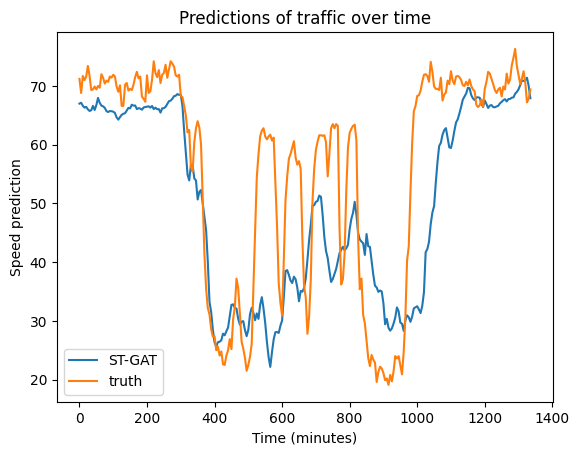

In [68]:
def plot_prediction(test_dataloader, y_pred, y_truth, node, config):
    # Extract the ground truth data for the given node
    s = y_truth.shape
    y_truth = y_truth.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    y_truth = y_truth[:, :, node, 0].flatten()[:config['N_SLOT']]

    # Extract the predicted data for the given node
    s = y_pred.shape
    y_pred = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    y_pred = y_pred[:, :, node, 0].flatten()[:config['N_SLOT']]

    # Create a plot of the predicted and ground truth data for the first day
    t = [t for t in range(0, config['N_SLOT']*5, 5)]
    plt.plot(t, y_pred, label='ST-GAT')
    plt.plot(t, y_truth, label='truth')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Speed prediction')
    plt.title('Predictions of traffic over time')
    plt.legend()
    plt.savefig('predicted_times.png')
    plt.show()

# Evaluate the model on the test set and plot predictions for node 0
with torch.no_grad():
    _, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')
plot_prediction(test_dataloader, y_pred, y_truth, 0, config)